In [1]:
# https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [2]:
# https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/372780

In [3]:
# https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [9]:
from xgboost import XGBRegressor

In [10]:
from sklearn.metrics import mean_squared_error

# 1. Load data

In [11]:
df = pd.read_csv('PJME_hourly.csv')

In [12]:
df.sample(5)

,Datetime,PJME_MW
83731,2011-06-12 16:00:00,36856.0
50019,2007-04-17 15:00:00,33702.0
102882,2013-04-06 19:00:00,26391.0
23024,2004-05-16 14:00:00,33378.0
15865,2003-03-10 06:00:00,31316.0


In [13]:
df.shape

(145366, 2)

# 2. Check data quality

data type

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [15]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [16]:
df.sort_values('Datetime', inplace=True)

unique value

In [17]:
df.shape

(145366, 2)

In [18]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Datetime
Unique value:  <DatetimeArray>
['2002-01-01 01:00:00', '2002-01-01 02:00:00', '2002-01-01 03:00:00',
 '2002-01-01 04:00:00', '2002-01-01 05:00:00', '2002-01-01 06:00:00',
 '2002-01-01 07:00:00', '2002-01-01 08:00:00', '2002-01-01 09:00:00',
 '2002-01-01 10:00:00',
 ...
 '2018-08-02 15:00:00', '2018-08-02 16:00:00', '2018-08-02 17:00:00',
 '2018-08-02 18:00:00', '2018-08-02 19:00:00', '2018-08-02 20:00:00',
 '2018-08-02 21:00:00', '2018-08-02 22:00:00', '2018-08-02 23:00:00',
 '2018-08-03 00:00:00']
Length: 145362, dtype: datetime64[ns]
Count unique value:  145362
----------
Columns name:  PJME_MW
Unique value:  [30393. 29265. 28357. ... 44094. 40666. 46816.]
Count unique value:  28441
----------


handle duplicate

In [19]:
df = df.groupby('Datetime')['PJME_MW'].mean().reset_index()

In [20]:
df

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145357,2018-08-02 20:00:00,44057.0
145358,2018-08-02 21:00:00,43256.0
145359,2018-08-02 22:00:00,41552.0
145360,2018-08-02 23:00:00,38500.0


check missing hour

In [21]:
start_timestamp = df['Datetime'].min()

In [22]:
end_timestamp = df['Datetime'].max()

In [23]:
hourly_timestamps = pd.date_range(start=start_timestamp, end=end_timestamp, freq='H')

In [24]:
df_hourly = pd.DataFrame(hourly_timestamps, columns=['Datetime'])

In [25]:
df_hourly = pd.merge(df_hourly, df, on = 'Datetime', how = 'left')

In [26]:
df_hourly

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145387,2018-08-02 20:00:00,44057.0
145388,2018-08-02 21:00:00,43256.0
145389,2018-08-02 22:00:00,41552.0
145390,2018-08-02 23:00:00,38500.0


In [27]:
df = df_hourly

missing value

In [28]:
df.isnull().sum()

Datetime     0
PJME_MW     30
dtype: int64

In [29]:
df[df.isnull().any(axis=1)]

,Datetime,PJME_MW
2306,2002-04-07 03:00:00,NaN
7177,2002-10-27 02:00:00,NaN
11042,2003-04-06 03:00:00,NaN
15913,2003-10-26 02:00:00,NaN
19778,2004-04-04 03:00:00,NaN
24817,2004-10-31 02:00:00,NaN
28514,2005-04-03 03:00:00,NaN
33553,2005-10-30 02:00:00,NaN
37250,2006-04-02 03:00:00,NaN
42289,2006-10-29 02:00:00,NaN


In [30]:
df['PJME_MW'] = df['PJME_MW'].fillna(method='ffill')

In [31]:
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

zero value

In [32]:
(df == 0).sum()

Datetime    0
PJME_MW     0
dtype: int64

blank value

In [33]:
(df == '').sum()

Datetime    0
PJME_MW     0
dtype: int64

copy for prediction

In [34]:
df_for_predict = df.copy()

# 3. Exploratory data analysis (EDA)

one day

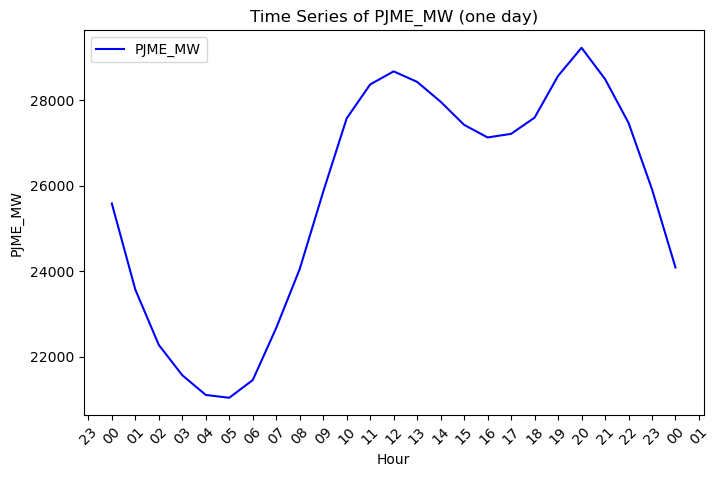

In [35]:
df_filtered = df[(df['Datetime'] >= '2002-10-12') & (df['Datetime'] <= '2002-10-13')]

plt.figure(figsize=(8, 5))
plt.plot(df_filtered['Datetime'], df_filtered['PJME_MW'], label='PJME_MW', color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xlabel('Hour')
plt.ylabel('PJME_MW')
plt.legend()
plt.title('Time Series of PJME_MW (one day)')
plt.xticks(rotation=45)
plt.show()

one week

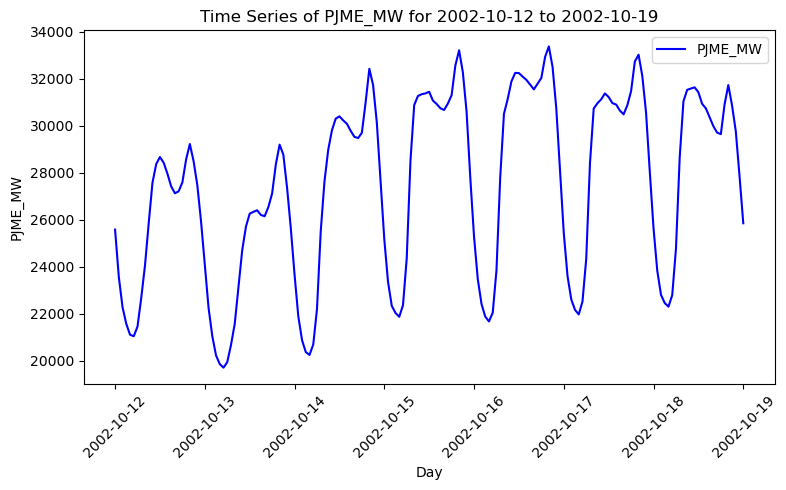

In [36]:
df_filtered = df[(df['Datetime'] >= '2002-10-12') & (df['Datetime'] <= '2002-10-19')]

plt.figure(figsize=(8, 5))
plt.plot(df_filtered['Datetime'], df_filtered['PJME_MW'], label='PJME_MW', color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xlabel('Day')
plt.ylabel('PJME_MW')
plt.legend()
plt.title('Time Series of PJME_MW for 2002-10-12 to 2002-10-19')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

one month

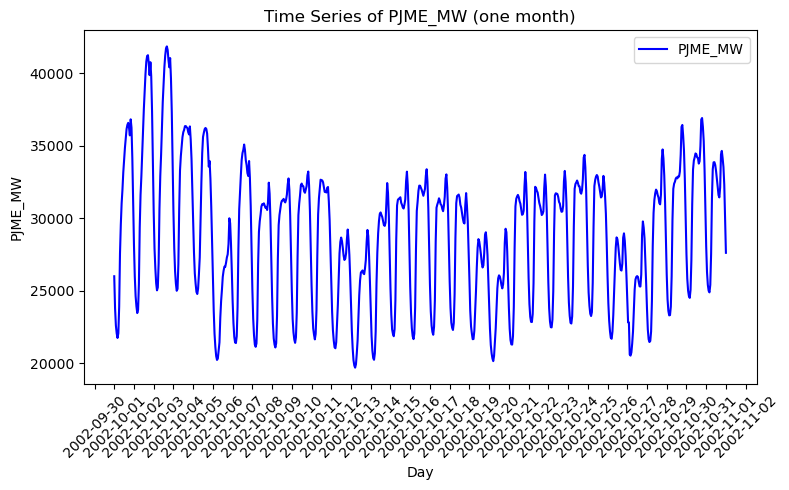

In [37]:
df_filtered = df[(df['Datetime'] >= '2002-10-01') & (df['Datetime'] <= '2002-11-01')]

plt.figure(figsize=(8, 5))
plt.plot(df_filtered['Datetime'], df_filtered['PJME_MW'], label='PJME_MW', color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xlabel('Day')
plt.ylabel('PJME_MW')
plt.legend()
plt.title('Time Series of PJME_MW (one month)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

one year

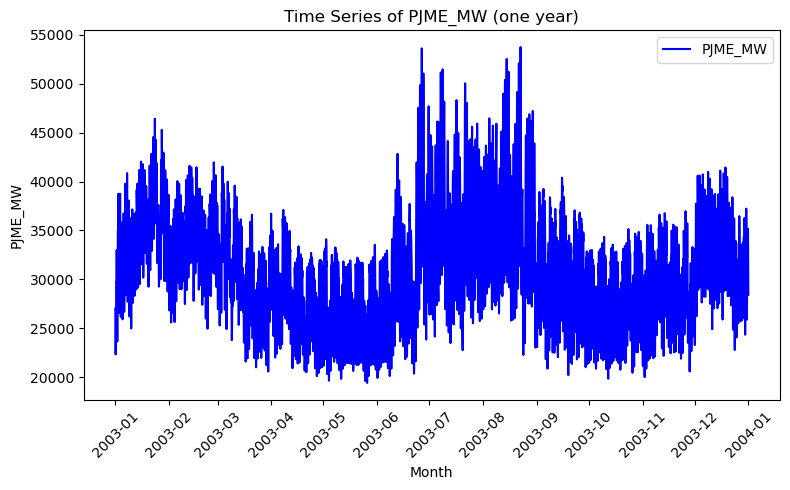

In [38]:
df_filtered = df[(df['Datetime'] >= '2003-01-01') & (df['Datetime'] <= '2004-01-01')]

plt.figure(figsize=(8, 5))
plt.plot(df_filtered['Datetime'], df_filtered['PJME_MW'], label='PJME_MW', color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Month')
plt.ylabel('PJME_MW')
plt.legend()
plt.title('Time Series of PJME_MW (one year)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

all year

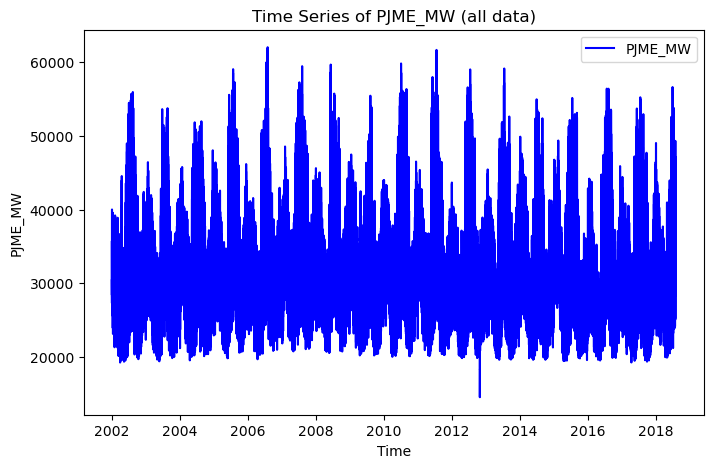

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(df['Datetime'], df['PJME_MW'], label='PJME_MW', color='blue')
plt.xlabel('Time')
plt.ylabel('PJME_MW')
plt.legend()
plt.title('Time Series of PJME_MW (all data)')
plt.show()

acf and pacf (day)

In [40]:
# 1 day = 24 hrs
# 1 week = 168 hrs
# 1 month = 720 hours
# 1 quarter = 2160
# 1 year = 8760 hours

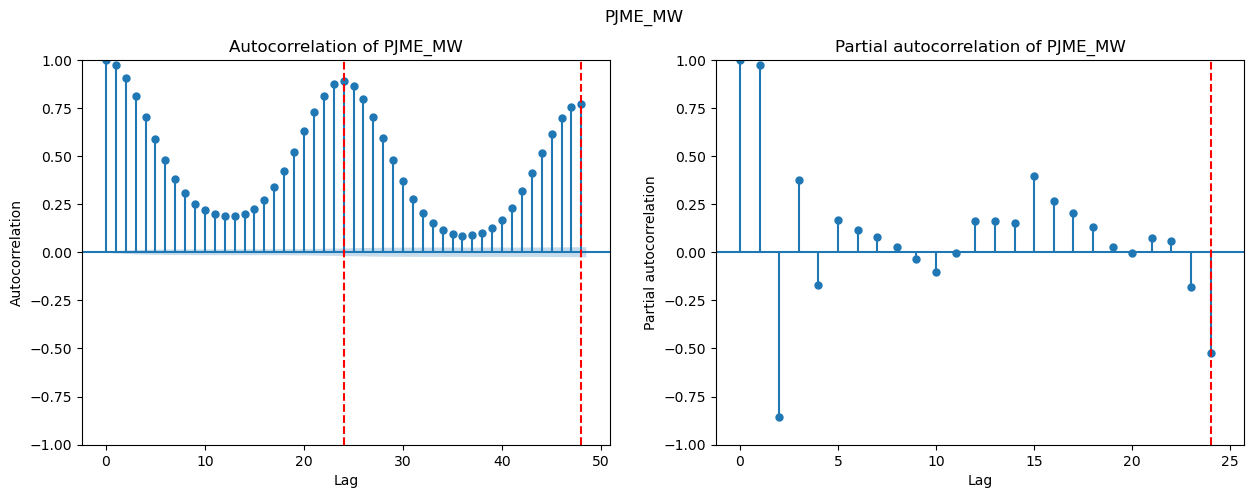

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=[15, 5])

plot_acf(df['PJME_MW'].dropna(), lags=24*2, ax=ax[0])
ax[0].set_title(f"Autocorrelation of PJME_MW")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].axvline(x=24, color='r', linestyle='--')
ax[0].axvline(x=24*2, color='r', linestyle='--')

plot_pacf(df['PJME_MW'].dropna(), lags=24*1, ax=ax[1], method="ywm")
ax[1].set_title(f"Partial autocorrelation of PJME_MW")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial autocorrelation")
ax[1].axvline(x=24, color='r', linestyle='--')

fig.suptitle('PJME_MW')
plt.show()

acf and pacf (week)

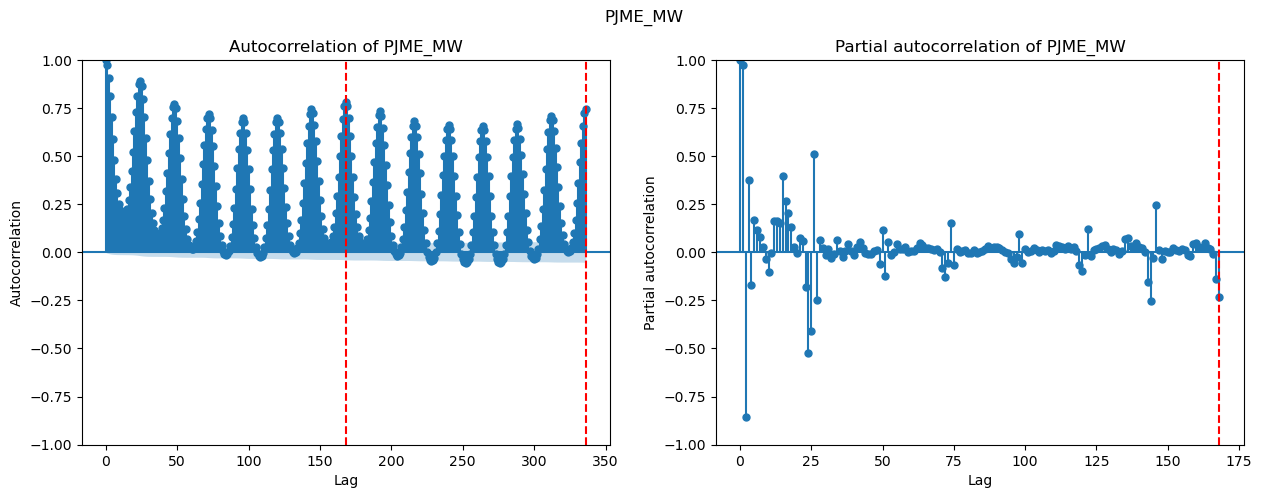

In [42]:
fig, ax = plt.subplots(ncols=2, figsize=[15, 5])

plot_acf(df['PJME_MW'].dropna(), lags=168*2, ax=ax[0])
ax[0].set_title(f"Autocorrelation of PJME_MW")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].axvline(x=168, color='r', linestyle='--')
ax[0].axvline(x=168*2, color='r', linestyle='--')

plot_pacf(df['PJME_MW'].dropna(), lags=168*1, ax=ax[1], method="ywm")
ax[1].set_title(f"Partial autocorrelation of PJME_MW")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial autocorrelation")
ax[1].axvline(x=168, color='r', linestyle='--')

fig.suptitle('PJME_MW')
plt.show()

acf and pacf (month)

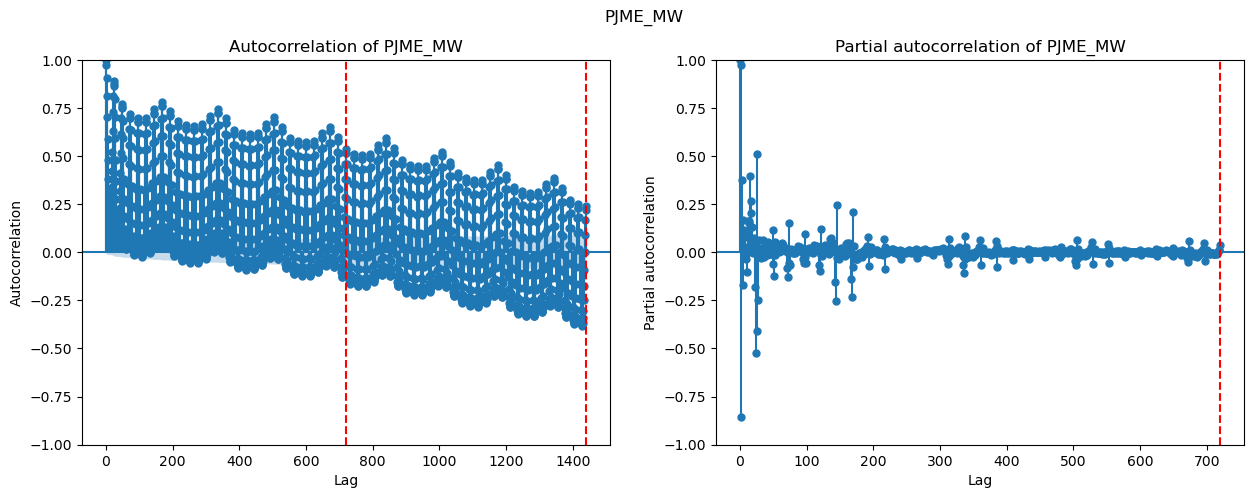

In [43]:
fig, ax = plt.subplots(ncols=2, figsize=[15, 5])

plot_acf(df['PJME_MW'].dropna(), lags=720*2, ax=ax[0])
ax[0].set_title(f"Autocorrelation of PJME_MW")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].axvline(x=720, color='r', linestyle='--')
ax[0].axvline(x=720*2, color='r', linestyle='--')

plot_pacf(df['PJME_MW'].dropna(), lags=720*1, ax=ax[1], method="ywm")
ax[1].set_title(f"Partial autocorrelation of PJME_MW")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial autocorrelation")
ax[1].axvline(x=720, color='r', linestyle='--')

fig.suptitle('PJME_MW')
plt.show()

acf and pacf (quarter)

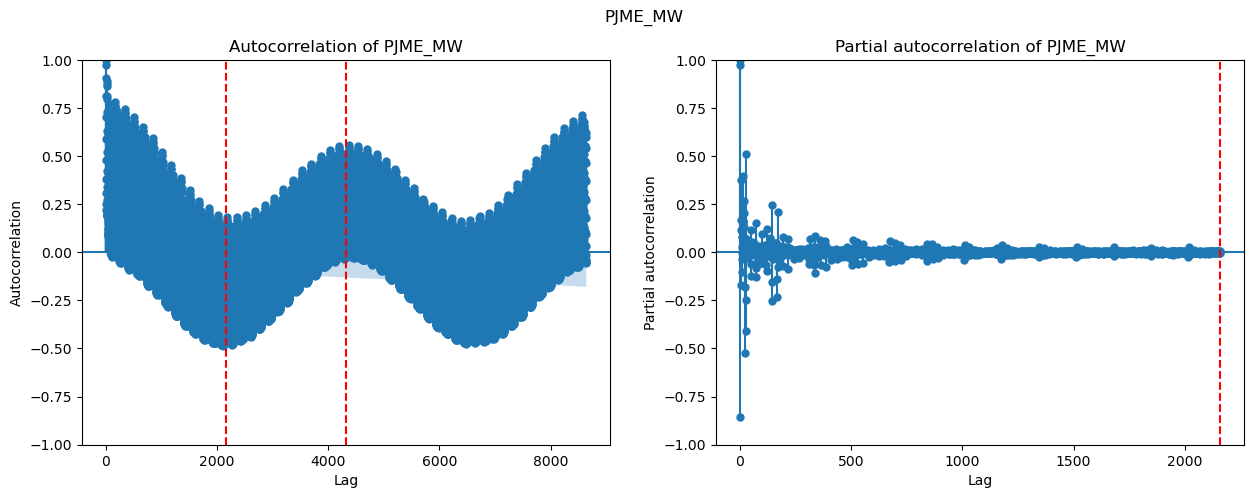

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=[15, 5])

plot_acf(df['PJME_MW'].dropna(), lags=2160*4, ax=ax[0])
ax[0].set_title(f"Autocorrelation of PJME_MW")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].axvline(x=2160, color='r', linestyle='--')
ax[0].axvline(x=2160*2, color='r', linestyle='--')

plot_pacf(df['PJME_MW'].dropna(), lags=2160*1, ax=ax[1], method="ywm")
ax[1].set_title(f"Partial autocorrelation of PJME_MW")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial autocorrelation")
ax[1].axvline(x=2160, color='r', linestyle='--')

fig.suptitle('PJME_MW')
plt.show()

# 3. Feature engineering

datetime features

In [47]:
def datetime_feature_extraction(df):
    # Day extraction
    df['hour'] = df['Datetime'].dt.hour
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['dayofmonth'] = df['Datetime'].dt.day
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['is_weekend'] = (df['Datetime'].dt.dayofweek >= 5).astype(int)
    df['is_month_start'] = df['Datetime'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Datetime'].dt.is_month_end.astype(int)
    df['is_year_start'] = df['Datetime'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['Datetime'].dt.is_year_end.astype(int)
    df['weekday_weekend'] = df['Datetime'].dt.dayofweek.apply(lambda x: 0 if x >= 5 else 1)

    # Week extraction
    df['weekofyear'] = df['Datetime'].dt.isocalendar().week
    df['weekofmonth'] = np.ceil(df['dayofmonth'] / 7).astype(int)    
    
    # Month extraction
    df['month'] = df['Datetime'].dt.month
    df['quarter'] = df['Datetime'].dt.quarter
    df['is_quarter_start'] = df['Datetime'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['Datetime'].dt.is_quarter_end.astype(int)
    df['days_in_month'] = df['Datetime'].dt.days_in_month

    # Year extraction
    df['year'] = df['Datetime'].dt.year
    df['year_since_2002'] = df['Datetime'].dt.year - 2002
    df['is_leap_year'] = df['Datetime'].dt.is_leap_year.astype(int)
    df['is_odd_year'] = (df['Datetime'].dt.year % 2 != 0).astype(int) # observed from data
    return df

In [48]:
df = datetime_feature_extraction(df)

In [49]:
df

,Datetime,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,is_weekend,is_month_start,is_month_end,is_year_start,...,weekofmonth,month,quarter,is_quarter_start,is_quarter_end,days_in_month,year,year_since_2002,is_leap_year,is_odd_year
0,2002-01-01 01:00:00,30393.0,1,1,1,1,0,1,0,1,...,1,1,1,1,0,31,2002,0,0,0
1,2002-01-01 02:00:00,29265.0,2,1,1,1,0,1,0,1,...,1,1,1,1,0,31,2002,0,0,0
2,2002-01-01 03:00:00,28357.0,3,1,1,1,0,1,0,1,...,1,1,1,1,0,31,2002,0,0,0
3,2002-01-01 04:00:00,27899.0,4,1,1,1,0,1,0,1,...,1,1,1,1,0,31,2002,0,0,0
4,2002-01-01 05:00:00,28057.0,5,1,1,1,0,1,0,1,...,1,1,1,1,0,31,2002,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145387,2018-08-02 20:00:00,44057.0,20,3,2,214,0,0,0,0,...,1,8,3,0,0,31,2018,16,0,0
145388,2018-08-02 21:00:00,43256.0,21,3,2,214,0,0,0,0,...,1,8,3,0,0,31,2018,16,0,0
145389,2018-08-02 22:00:00,41552.0,22,3,2,214,0,0,0,0,...,1,8,3,0,0,31,2018,16,0,0
145390,2018-08-02 23:00:00,38500.0,23,3,2,214,0,0,0,0,...,1,8,3,0,0,31,2018,16,0,0


lag features

In [50]:
# 1 day = 24 hrs
# 1 week = 168 hrs
# 1 month = 720 hours
# 1 quarter = 2160
# 1 year = 8760 hours

In [51]:
def lag_feature_extraction(df):
    lag_hours = [1, 2, 3, 6, 12, 24, 168, 720, 2160, 8760]

    for lag in lag_hours:
        df[f'PJME_MW_lag_{lag}h'] = df['PJME_MW'].shift(periods=lag)
    df.fillna(method='bfill', inplace=True)

    return df

In [52]:
df = lag_feature_extraction(df)

In [53]:
df

,Datetime,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,is_weekend,is_month_start,is_month_end,is_year_start,...,PJME_MW_lag_1h,PJME_MW_lag_2h,PJME_MW_lag_3h,PJME_MW_lag_6h,PJME_MW_lag_12h,PJME_MW_lag_24h,PJME_MW_lag_168h,PJME_MW_lag_720h,PJME_MW_lag_2160h,PJME_MW_lag_8760h
0,2002-01-01 01:00:00,30393.0,1,1,1,1,0,1,0,1,...,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
1,2002-01-01 02:00:00,29265.0,2,1,1,1,0,1,0,1,...,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
2,2002-01-01 03:00:00,28357.0,3,1,1,1,0,1,0,1,...,29265.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
3,2002-01-01 04:00:00,27899.0,4,1,1,1,0,1,0,1,...,28357.0,29265.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
4,2002-01-01 05:00:00,28057.0,5,1,1,1,0,1,0,1,...,27899.0,28357.0,29265.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145387,2018-08-02 20:00:00,44057.0,20,3,2,214,0,0,0,0,...,45641.0,46760.0,46816.0,46534.0,35645.0,46912.0,46337.0,49244.0,37269.0,39352.0
145388,2018-08-02 21:00:00,43256.0,21,3,2,214,0,0,0,0,...,44057.0,45641.0,46760.0,47154.0,37810.0,45985.0,44542.0,47292.0,37244.0,38699.0
145389,2018-08-02 22:00:00,41552.0,22,3,2,214,0,0,0,0,...,43256.0,44057.0,45641.0,46989.0,39902.0,44094.0,42638.0,45506.0,35617.0,37346.0
145390,2018-08-02 23:00:00,38500.0,23,3,2,214,0,0,0,0,...,41552.0,43256.0,44057.0,46816.0,42189.0,40666.0,39276.0,42437.0,33295.0,34555.0


rolling windows

In [54]:
def rolling_feature_extraction(df):
    rolling_periods = [12, 24, 168, 720, 2160, 8760]

    for period in rolling_periods:
        df[f'PJME_MW_MA_{period}h_mean'] = df['PJME_MW'].rolling(window=period).mean().shift(1)
        df[f'PJME_MW_MA_{period}h_min'] = df['PJME_MW'].rolling(window=period).min().shift(1)
        df[f'PJME_MW_MA_{period}h_max'] = df['PJME_MW'].rolling(window=period).max().shift(1)
        df[f'PJME_MW_MA_{period}h_std'] = df['PJME_MW'].rolling(window=period).std().shift(1)

    return df

In [55]:
df = rolling_feature_extraction(df)

In [56]:
df

,Datetime,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,is_weekend,is_month_start,is_month_end,is_year_start,...,PJME_MW_MA_720h_max,PJME_MW_MA_720h_std,PJME_MW_MA_2160h_mean,PJME_MW_MA_2160h_min,PJME_MW_MA_2160h_max,PJME_MW_MA_2160h_std,PJME_MW_MA_8760h_mean,PJME_MW_MA_8760h_min,PJME_MW_MA_8760h_max,PJME_MW_MA_8760h_std
0,2002-01-01 01:00:00,30393.0,1,1,1,1,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-01 02:00:00,29265.0,2,1,1,1,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-01-01 03:00:00,28357.0,3,1,1,1,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-01-01 04:00:00,27899.0,4,1,1,1,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-01-01 05:00:00,28057.0,5,1,1,1,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145387,2018-08-02 20:00:00,44057.0,20,3,2,214,0,0,0,0,...,53764.0,7286.979834,32691.959722,19937.0,56609.0,7504.585682,31196.330137,19367.0,56609.0,6054.217457
145388,2018-08-02 21:00:00,43256.0,21,3,2,214,0,0,0,0,...,53764.0,7276.625275,32695.102315,19937.0,56609.0,7507.923751,31196.867237,19367.0,56609.0,6055.149701
145389,2018-08-02 22:00:00,41552.0,22,3,2,214,0,0,0,0,...,53764.0,7269.616216,32697.885648,19937.0,56609.0,7510.724757,31197.387443,19367.0,56609.0,6055.989982
145390,2018-08-02 23:00:00,38500.0,23,3,2,214,0,0,0,0,...,53764.0,7264.059984,32700.633333,19937.0,56609.0,7512.878471,31197.867580,19367.0,56609.0,6056.644215


drop na

In [57]:
df = df.dropna()

In [58]:
df.isna().sum()

Datetime                 0
PJME_MW                  0
hour                     0
dayofweek                0
dayofmonth               0
dayofyear                0
is_weekend               0
is_month_start           0
is_month_end             0
is_year_start            0
is_year_end              0
weekday_weekend          0
weekofyear               0
weekofmonth              0
month                    0
quarter                  0
is_quarter_start         0
is_quarter_end           0
days_in_month            0
year                     0
year_since_2002          0
is_leap_year             0
is_odd_year              0
PJME_MW_lag_1h           0
PJME_MW_lag_2h           0
PJME_MW_lag_3h           0
PJME_MW_lag_6h           0
PJME_MW_lag_12h          0
PJME_MW_lag_24h          0
PJME_MW_lag_168h         0
PJME_MW_lag_720h         0
PJME_MW_lag_2160h        0
PJME_MW_lag_8760h        0
PJME_MW_MA_12h_mean      0
PJME_MW_MA_12h_min       0
PJME_MW_MA_12h_max       0
PJME_MW_MA_12h_std       0
P

correlation

In [59]:
corr = df.corr()

<Axes: >

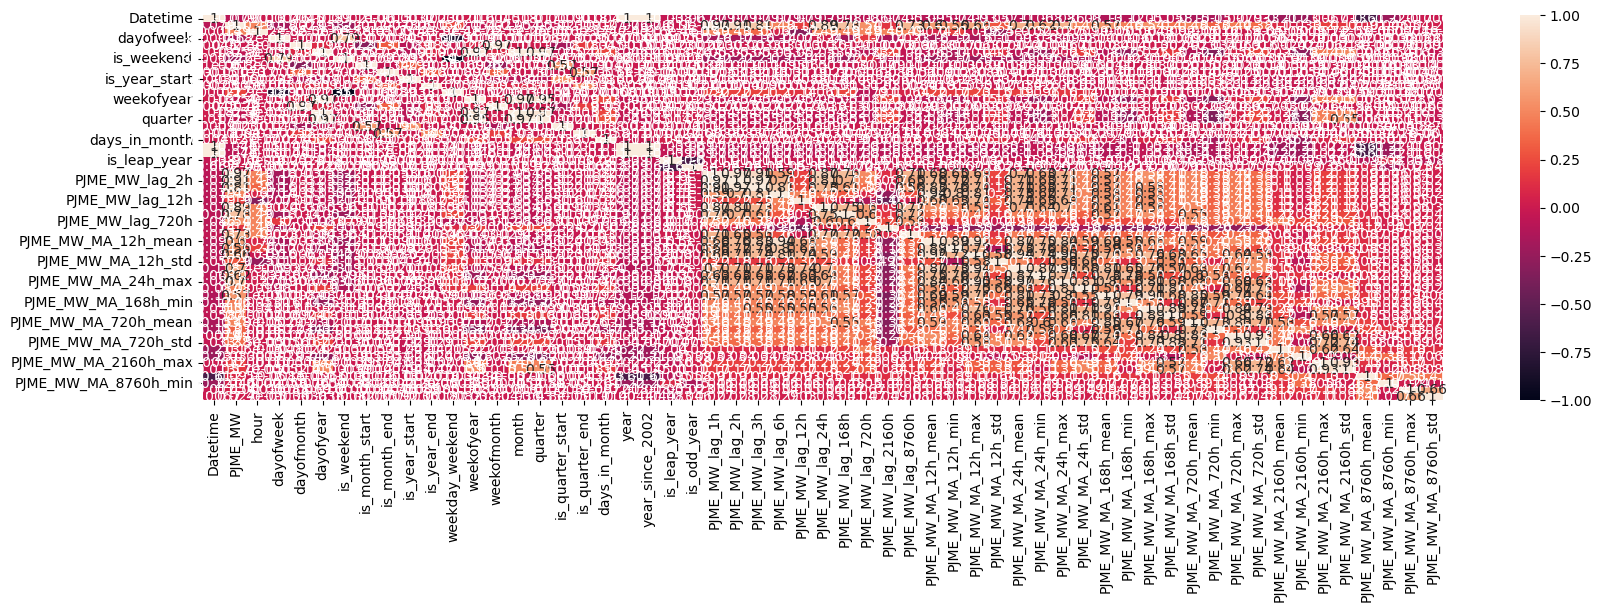

In [60]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr, annot=True, ax=ax)

In [61]:
corr_churn_table = corr['PJME_MW'].sort_values(ascending=False)

In [62]:
corr_churn_table.head(20)

PJME_MW                 1.000000
PJME_MW_lag_1h          0.974799
PJME_MW_lag_2h          0.907599
PJME_MW_lag_24h         0.892471
PJME_MW_lag_3h          0.812611
PJME_MW_lag_168h        0.783758
PJME_MW_lag_8760h       0.729948
PJME_MW_MA_24h_max      0.703073
PJME_MW_MA_24h_mean     0.696737
PJME_MW_MA_12h_max      0.659787
PJME_MW_MA_24h_min      0.624770
PJME_MW_MA_12h_mean     0.599381
PJME_MW_MA_168h_mean    0.566356
PJME_MW_MA_12h_min      0.561362
PJME_MW_MA_168h_max     0.542699
PJME_MW_lag_720h        0.539880
hour                    0.486198
PJME_MW_MA_720h_mean    0.481801
PJME_MW_MA_24h_std      0.481038
PJME_MW_lag_6h          0.476658
Name: PJME_MW, dtype: float64

In [63]:
corr_churn_abs_table = corr['PJME_MW'].abs().sort_values(ascending=False)

In [64]:
corr_churn_abs_table.head(20)

PJME_MW                 1.000000
PJME_MW_lag_1h          0.974799
PJME_MW_lag_2h          0.907599
PJME_MW_lag_24h         0.892471
PJME_MW_lag_3h          0.812611
PJME_MW_lag_168h        0.783758
PJME_MW_lag_8760h       0.729948
PJME_MW_MA_24h_max      0.703073
PJME_MW_MA_24h_mean     0.696737
PJME_MW_MA_12h_max      0.659787
PJME_MW_MA_24h_min      0.624770
PJME_MW_MA_12h_mean     0.599381
PJME_MW_MA_168h_mean    0.566356
PJME_MW_MA_12h_min      0.561362
PJME_MW_MA_168h_max     0.542699
PJME_MW_lag_720h        0.539880
hour                    0.486198
PJME_MW_MA_720h_mean    0.481801
PJME_MW_MA_24h_std      0.481038
PJME_MW_lag_6h          0.476658
Name: PJME_MW, dtype: float64

# 4. Model

In [65]:
df

,Datetime,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,is_weekend,is_month_start,is_month_end,is_year_start,...,PJME_MW_MA_720h_max,PJME_MW_MA_720h_std,PJME_MW_MA_2160h_mean,PJME_MW_MA_2160h_min,PJME_MW_MA_2160h_max,PJME_MW_MA_2160h_std,PJME_MW_MA_8760h_mean,PJME_MW_MA_8760h_min,PJME_MW_MA_8760h_max,PJME_MW_MA_8760h_std
8760,2003-01-01 01:00:00,25591.0,1,2,1,1,0,1,0,1,...,42386.0,4369.597877,30232.233796,19702.0,42386.0,4581.750585,31563.319406,19247.0,55934.0,6608.708405
8761,2003-01-01 02:00:00,24235.0,2,2,1,1,0,1,0,1,...,42386.0,4373.801454,30231.157407,19702.0,42386.0,4582.568022,31562.771233,19247.0,55934.0,6609.004640
8762,2003-01-01 03:00:00,23121.0,3,2,1,1,0,1,0,1,...,42386.0,4379.914960,30230.087963,19702.0,42386.0,4583.698073,31562.197032,19247.0,55934.0,6609.422791
8763,2003-01-01 04:00:00,22445.0,4,2,1,1,0,1,0,1,...,42386.0,4388.492976,30228.976852,19702.0,42386.0,4585.130770,31561.599315,19247.0,55934.0,6609.949419
8764,2003-01-01 05:00:00,22332.0,5,2,1,1,0,1,0,1,...,42386.0,4399.174638,30227.778704,19702.0,42386.0,4586.826992,31560.976712,19247.0,55934.0,6610.551278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145387,2018-08-02 20:00:00,44057.0,20,3,2,214,0,0,0,0,...,53764.0,7286.979834,32691.959722,19937.0,56609.0,7504.585682,31196.330137,19367.0,56609.0,6054.217457
145388,2018-08-02 21:00:00,43256.0,21,3,2,214,0,0,0,0,...,53764.0,7276.625275,32695.102315,19937.0,56609.0,7507.923751,31196.867237,19367.0,56609.0,6055.149701
145389,2018-08-02 22:00:00,41552.0,22,3,2,214,0,0,0,0,...,53764.0,7269.616216,32697.885648,19937.0,56609.0,7510.724757,31197.387443,19367.0,56609.0,6055.989982
145390,2018-08-02 23:00:00,38500.0,23,3,2,214,0,0,0,0,...,53764.0,7264.059984,32700.633333,19937.0,56609.0,7512.878471,31197.867580,19367.0,56609.0,6056.644215


In [66]:
df_for_predict

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145387,2018-08-02 20:00:00,44057.0
145388,2018-08-02 21:00:00,43256.0
145389,2018-08-02 22:00:00,41552.0
145390,2018-08-02 23:00:00,38500.0


train-test split

In [67]:
df = df.sort_values('Datetime')

In [68]:
df.drop(columns=['Datetime'], inplace=True)

In [69]:
X = df.drop(columns=['PJME_MW'])
y = df['PJME_MW']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

model

In [71]:
model = XGBRegressor()

In [72]:
tscv = TimeSeriesSplit(n_splits = 5)

In [73]:
param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2]
}

In [74]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

In [75]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 7, 10],
                         'n_estimators': [1000, 1500, 2000]},
             scoring='neg_mean_squared_error')

In [76]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}

In [77]:
grid_search.best_score_

-207034.0397992712

evaluate

In [78]:
y_pred = grid_search.predict(X_test)

In [79]:
mse = mean_squared_error(y_test, y_pred)

In [80]:
-mse

-91075.44861274178

# 5. Predict

In [81]:
df_for_predict

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145387,2018-08-02 20:00:00,44057.0
145388,2018-08-02 21:00:00,43256.0
145389,2018-08-02 22:00:00,41552.0
145390,2018-08-02 23:00:00,38500.0


In [82]:
last_timestamp = df_for_predict['Datetime'].max()

In [83]:
last_timestamp

Timestamp('2018-08-03 00:00:00')

In [84]:
future_timestamps = [last_timestamp + pd.Timedelta(hours=i) for i in range(1, 24*365*2)]

In [85]:
future_predictions = []

In [86]:
# recursive

In [87]:
for timestamp in future_timestamps:
    # Prep features
    df_feature = pd.DataFrame([[timestamp, None]], columns=['Datetime', 'PJME_MW'])
    future_predictions = pd.concat([df_for_predict, df_feature], ignore_index=True, sort=False)
    df_for_predict_feature = datetime_feature_extraction(future_predictions)
    df_for_predict_feature = lag_feature_extraction(df_for_predict_feature)
    df_for_predict_feature = rolling_feature_extraction(df_for_predict_feature)
    df_for_predict_feature = df_for_predict_feature.tail(1).iloc[:,2:]
    y_predicted = grid_search.predict(df_for_predict_feature)[0]
    # Predict
    df_predicted = pd.DataFrame([[timestamp, y_predicted]], columns=['Datetime', 'PJME_MW'])
    # Append
    df_for_predict = pd.concat([df_for_predict, df_predicted], ignore_index=True, sort=False)
    # # Print
    print(timestamp, y_predicted)

2018-08-03 01:00:00 32633.346
2018-08-03 02:00:00 30888.822
2018-08-03 03:00:00 29520.86
2018-08-03 04:00:00 28726.686
2018-08-03 05:00:00 28685.092
2018-08-03 06:00:00 29810.457
2018-08-03 07:00:00 31604.697
2018-08-03 08:00:00 34201.06
2018-08-03 09:00:00 36643.98
2018-08-03 10:00:00 38651.617
2018-08-03 11:00:00 40597.574
2018-08-03 12:00:00 42059.13
2018-08-03 13:00:00 43434.848
2018-08-03 14:00:00 44587.973
2018-08-03 15:00:00 45394.93
2018-08-03 16:00:00 46067.586
2018-08-03 17:00:00 46599.016
2018-08-03 18:00:00 46787.742
2018-08-03 19:00:00 45607.3
2018-08-03 20:00:00 43844.004
2018-08-03 21:00:00 43169.684
2018-08-03 22:00:00 42256.934
2018-08-03 23:00:00 39638.49
2018-08-04 00:00:00 36683.234
2018-08-04 01:00:00 33885.285
2018-08-04 02:00:00 31840.873
2018-08-04 03:00:00 30510.686
2018-08-04 04:00:00 29666.611
2018-08-04 05:00:00 29368.008
2018-08-04 06:00:00 29720.18
2018-08-04 07:00:00 30511.607
2018-08-04 08:00:00 32288.5
2018-08-04 09:00:00 35111.16
2018-08-04 10:00:00 37

In [88]:
df_for_predict['predict_flag'] = np.where(df_for_predict['Datetime'] <= last_timestamp, 'Actual', 'Predicted')

In [89]:
df_for_predict

,Datetime,PJME_MW,predict_flag
0,2002-01-01 01:00:00,30393.000000,Actual
1,2002-01-01 02:00:00,29265.000000,Actual
2,2002-01-01 03:00:00,28357.000000,Actual
3,2002-01-01 04:00:00,27899.000000,Actual
4,2002-01-01 05:00:00,28057.000000,Actual
...,...,...,...
162906,2020-08-01 19:00:00,30759.121094,Predicted
162907,2020-08-01 20:00:00,30600.917969,Predicted
162908,2020-08-01 21:00:00,30783.853516,Predicted
162909,2020-08-01 22:00:00,30364.841797,Predicted


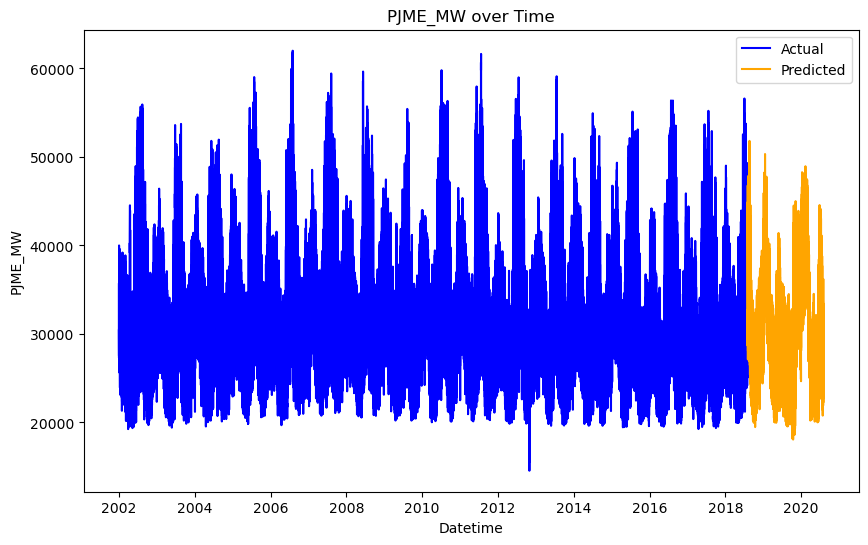

In [90]:
plt.figure(figsize=(10, 6))
actual_data = df_for_predict[df_for_predict['predict_flag'] == 'Actual']
predicted_data = df_for_predict[df_for_predict['predict_flag'] == 'Predicted']
plt.plot(actual_data['Datetime'], actual_data['PJME_MW'], color='blue', label='Actual')
plt.plot(predicted_data['Datetime'], predicted_data['PJME_MW'], color='orange', label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW') 
plt.title('PJME_MW over Time')
plt.legend()
plt.show()